In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as spst
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic      #mosaic plot!
from statsmodels.graphics.mosaicplot import mosaic   
plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic",#"NanumGothicCoding", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')   

In [27]:
import seaborn as sns
print(sns.__version__)

0.11.0


# 1. 전처리

In [28]:
path = 'customer_data_.csv'

df = pd.read_csv( path , encoding = 'CP949')
df.head()

,clust,AGE,등록(계/피),고용상태,성별,Willingness to pay/Stay,갱신,상품타입,교육수준,소득,...,결혼여부,월 납입액,VOC,타 상품 보유 현황,온라인방문빈도,갱신인센티브,판매채널,총지불금액,자동차,거주지사이즈
0,2,3,피보험자,무직,1,2.616381,0,기본,대학졸업,0,...,미혼,80000,0,1,자주방문,없음,자사영업,631000,일반세단,소
1,4,1,계약자,고용,0,6.352530,0,기본,고졸이하,102887400,...,미혼,80000,1,4이상,비방문,포인트,인터넷,54000,일반세단,중
2,5,2,계약자,휴직,0,4.974354,0,기본,대학졸업,22159500,...,기혼,60000,0,4이상,비방문,할인,자사영업,362000,일반세단,중
3,0,5,계약자,고용,1,13.480284,0,고급,고졸이하,51562500,...,기혼,110000,0,2,비방문,할인,자사영업,1264000,컴팩트카,대
4,3,4,계약자,고용,0,9.776436,0,기본,석사,26820200,...,기혼,120000,0,3,비방문,없음,대리점,947000,SUV,중


In [29]:
target = ['자동차','소득']

x = df.drop( target , axis = 1)
y = df[target]

In [30]:
len(x.columns)

19

In [31]:
x.columns

Index(['clust', 'AGE', '등록(계/피)', '고용상태', '성별', 'Willingness to pay/Stay',
       '갱신', '상품타입', '교육수준', '지역', '결혼여부', '월 납입액', 'VOC', '타 상품 보유 현황',
       '온라인방문빈도', '갱신인센티브', '판매채널', '총지불금액', '거주지사이즈'],
      dtype='object')

### 1-1. 범주형이면서 object인 것들 라벨링

In [32]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
drop_cols = ['총지불금액','Willingness to pay/Stay']
x_int = x[drop_cols]
x_object = x.select_dtypes(include = 'object' )  

encoders = {}
label_data = {}

for col in x_object.columns:
    le = LabelEncoder()
    le.fit(x_object[col])
    labels = le.transform(x_object[col])
    x_object[col] = labels
    
    encoders[col] = le
    label_data[col] = labels
    
x_num = x.select_dtypes(include = 'int' )
x_num1 = x_num.drop(['총지불금액'],axis =1)
x_bum1 = pd.concat( [x_num1 , x_object] , axis = 1)
x_1 = pd.concat( [x_int,x_bum1] , axis = 1)

In [33]:
len(x_1.columns)

19

In [34]:
x_1.columns

Index(['총지불금액', 'Willingness to pay/Stay', 'clust', 'AGE', '성별', '갱신', '월 납입액',
       'VOC', '등록(계/피)', '고용상태', '상품타입', '교육수준', '지역', '결혼여부', '타 상품 보유 현황',
       '온라인방문빈도', '갱신인센티브', '판매채널', '거주지사이즈'],
      dtype='object')

### 1-2. target의 자동차 칼럼도 라벨링진행

In [35]:
le.fit( y['자동차'] )
labels = le.transform( y['자동차'])
y['자동차'] = labels
encoders['자동차'] = le
label_data['자동차'] = labels

In [36]:
encoders

{'등록(계/피)': LabelEncoder(),
 '고용상태': LabelEncoder(),
 '상품타입': LabelEncoder(),
 '교육수준': LabelEncoder(),
 '지역': LabelEncoder(),
 '결혼여부': LabelEncoder(),
 '타 상품 보유 현황': LabelEncoder(),
 '온라인방문빈도': LabelEncoder(),
 '갱신인센티브': LabelEncoder(),
 '판매채널': LabelEncoder(),
 '거주지사이즈': LabelEncoder(),
 '자동차': LabelEncoder()}

In [37]:
y

,자동차,소득
0,3,0
1,3,102887400
2,3,22159500
3,4,51562500
4,0,26820200
...,...,...
11995,3,86451000
11996,3,25962000
11997,3,0
11998,3,26366000


### 1-3. 2차 EDA결과대로 Standard스케일링 진행

In [38]:
from sklearn.preprocessing import StandardScaler
col_x = list(x_1)
scaler = StandardScaler()
x_2 = scaler.fit_transform(x_1)
x_2 = pd.DataFrame(x_2, columns=col_x)

### 1-4. train test 데이터 분리

In [39]:
from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test = train_test_split( x_2 , y , test_size= 0.3 , random_state= 1)

### 1-5. 필요 라이브러리 부르기 / target 세부 지정

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
target1 = '자동차'
target2 = '소득'

# 2. ML 모델링

In [41]:
# 1 DecisionTree
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor( random_state= 1)
cv_score = cross_val_score( dt_model , x_train , y_train ,cv=5 , scoring='r2')
print(cv_score.mean())
dt_model.fit(x_train , y_train)

dt_pred = dt_model.predict( x_test )

0.6608081167113827


In [42]:
dt = pd.DataFrame( dt_pred , columns = list(y) )

#### 결과 값의 특성파악

In [43]:
dt

,자동차,소득
0,0.0,86924000.0
1,3.0,57207700.0
2,4.0,34667000.0
3,4.0,0.0
4,4.0,0.0
...,...,...
3595,1.0,0.0
3596,3.0,60760000.0
3597,0.0,25013000.0
3598,0.0,17028000.0


In [44]:
dt['자동차'].unique()

array([0., 3., 4., 1., 2.])

#### 범주값을 시각화 하는 방법: confusion matrix 와 heatmap으로 명료하게 표현

In [45]:
y_pred = dt

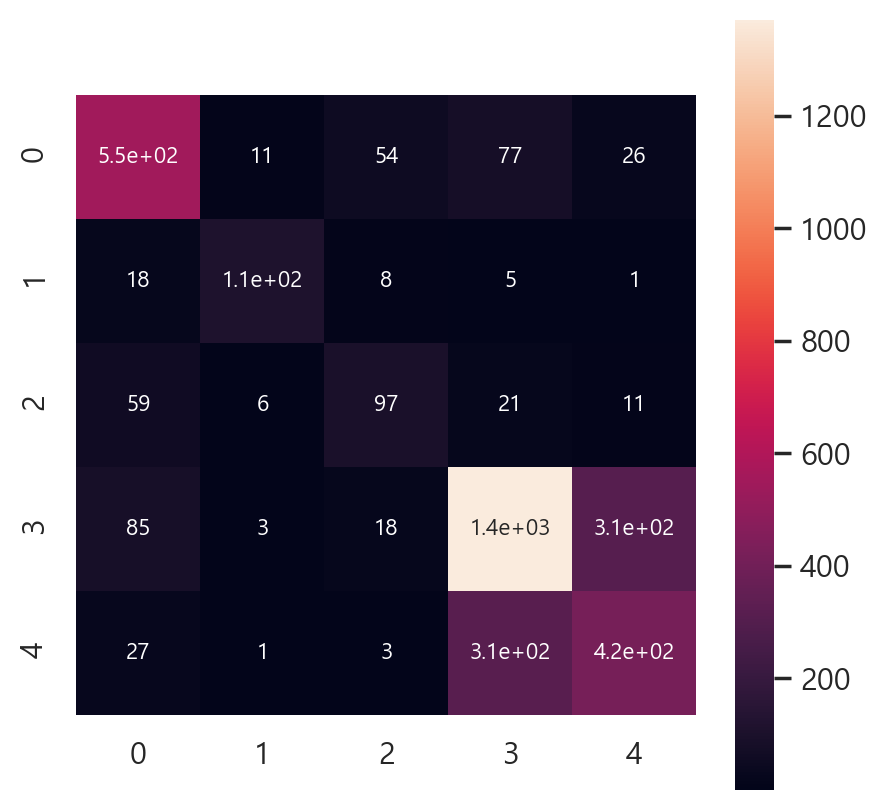

In [46]:
a = confusion_matrix( y_test[target1], y_pred[target1] )
plt.figure( figsize = (5,5))
sns.heatmap( a , annot = True , cbar = True , square= True , annot_kws= {'size': 8} )
plt.show()         

#### 수치형 데이터 시각화는 lineplot과 실제값의 평균으로 표현

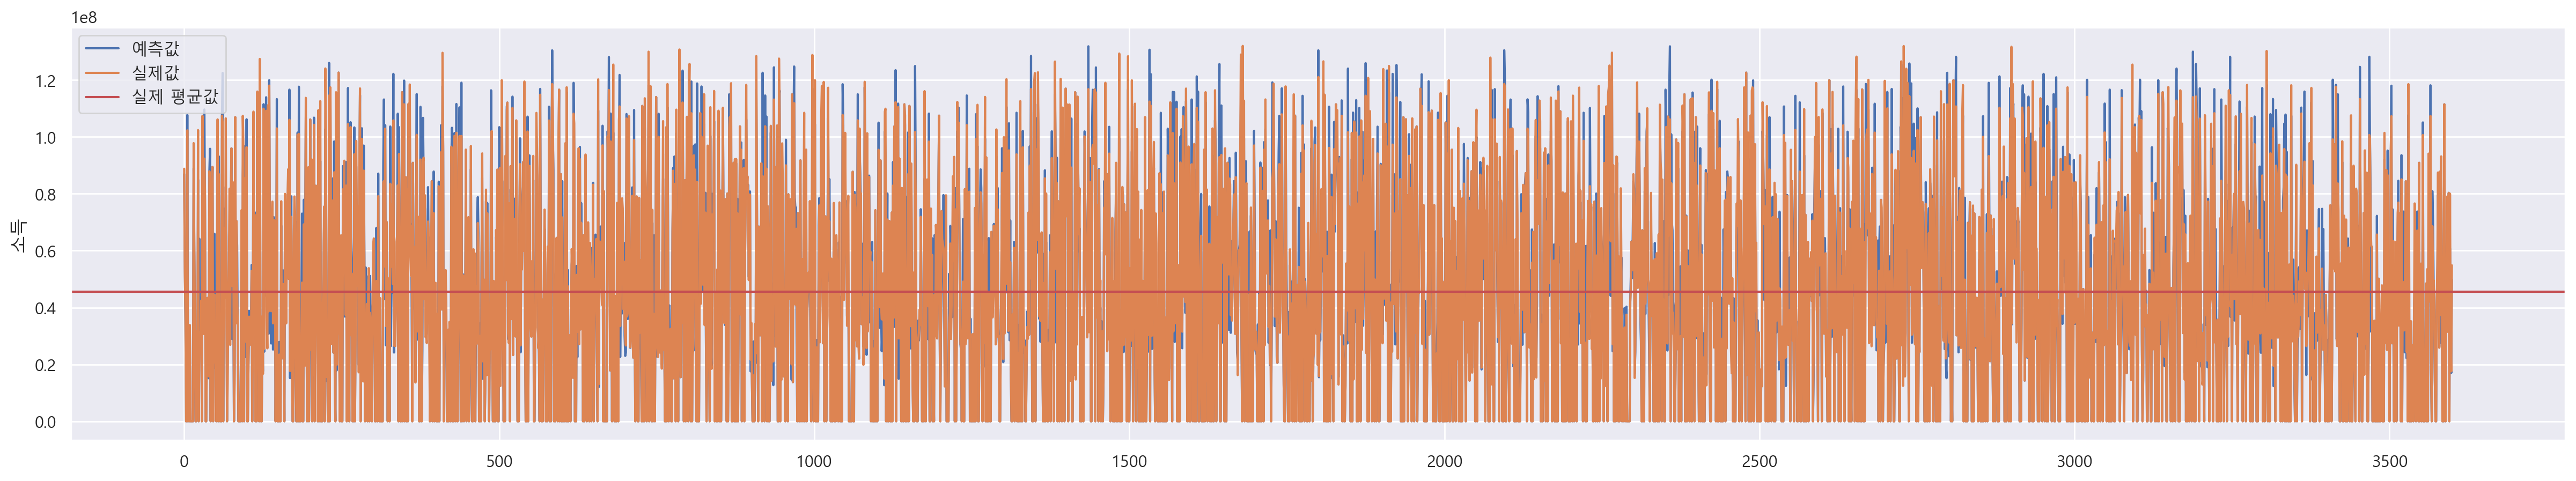

In [47]:
plt.figure( figsize = (30,5))
sns.lineplot(data=y_pred, y=target2, x=y_pred.index ,label = '예측값' )
sns.lineplot(data=y_test, y=target2, x=y_pred.index ,label = '실제값' )
plt.axhline( y_test[target2].mean() , color = 'r' , label = '실제 평균값')
plt.legend()
plt.show()

In [48]:
# 평가 및 result 함수에 저장
result = pd.DataFrame(columns=['data', 'model_name', 'MAE', 'R2' , 'Accuracy' , 'CV score'])
result

,data,model_name,MAE,R2,Accuracy,CV score


#### 1차 모델링때는 전체의 MAE R2값을 저장했으나, 이번엔 범주형의 경우 Accuracy , 숫자형은 MAE와 R2로 각각 도출하여 저장

In [49]:
from sklearn.metrics import r2_score , mean_absolute_error

y_pred = dt_pred
print( 'MAE:' , mean_absolute_error( y_test , y_pred ))
print( '\nR2:' , r2_score( y_test , y_pred ))

MAE: 2997096.177777778

R2: 0.709719088901598


In [50]:
y_pred = dt_pred
y_pred = pd.DataFrame( y_pred , columns = list(y))
target1 = '자동차'
target2 = '소득'
result.loc[0] = ['df', 'Decision tree', mean_absolute_error(y_test[target2] , y_pred[target2]), r2_score(y_test[target2] , y_pred[target2]), accuracy_score( y_test[target1] , y_pred[target1] ) ,cv_score.mean() ]
result

,data,model_name,MAE,R2,Accuracy,CV score
0,df,Decision tree,5.994192e+06,0.928653,0.706111,0.660808


# 2-1. 이후 각각 모든 모델에 대해 동일한 과정 진행

In [51]:
x_train_s = x_train.copy()
x_test_s = x_test.copy()
target1 = '자동차'
target2 = '소득'
# 2 KNN
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor( n_neighbors= 3 )
cv_score = cross_val_score( knn_model , x_train_s , y_train ,cv=5 , scoring='r2')
print(cv_score.mean())
knn_model.fit( x_train_s , y_train)
knn_pred = knn_model.predict( x_test_s)
# 평가 및 저장 
y_pred = knn_pred
y_pred = pd.DataFrame( y_pred , columns = list(y))
y_pred['자동차'] = y_pred['자동차'].round().astype(int)
print( confusion_matrix( y_test[target1] , y_pred[target1] ))
print( classification_report( y_test[target1] , y_pred[target1] ))
print( 'MAE:' , mean_absolute_error(y_test[target2] , y_pred[target2]))
print( '\nR2:' , r2_score(y_test[target2] , y_pred[target2]))
result.loc[1] = ['df', 'KNN',  mean_absolute_error(y_test[target2] , y_pred[target2]), r2_score(y_test[target2] , y_pred[target2]), accuracy_score( y_test[target1] , y_pred[target1] ) ,cv_score.mean() ]
result

0.6174703870760017
[[ 264  209  147   81   17]
 [   4  133    3    0    0]
 [  14   51   84   40    5]
 [   8   39  204 1289  246]
 [   2   22   73  400  265]]
              precision    recall  f1-score   support

           0       0.90      0.37      0.52       718
           1       0.29      0.95      0.45       140
           2       0.16      0.43      0.24       194
           3       0.71      0.72      0.72      1786
           4       0.50      0.35      0.41       762

    accuracy                           0.57      3600
   macro avg       0.51      0.56      0.47      3600
weighted avg       0.66      0.57      0.58      3600

MAE: 10385126.48148148

R2: 0.8003201296214958


,data,model_name,MAE,R2,Accuracy,CV score
0,df,Decision tree,5.994192e+06,0.928653,0.706111,0.660808
1,df,KNN,1.038513e+07,0.800320,0.565278,0.617470


In [52]:
# 3 linearRegression
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
cv_score = cross_val_score( lr_model , x_train , y_train ,cv=5 , scoring='r2')
print(cv_score.mean())
lr_model.fit(x_train, y_train)
lr_pred = lr_model.predict( x_test )
# 평가 및 저장 
y_pred = lr_pred
y_pred = pd.DataFrame( y_pred , columns = list(y))
y_pred['자동차'] = y_pred['자동차'].round().astype(int)
print( confusion_matrix( y_test[target1] , y_pred[target1] ))
print( classification_report( y_test[target1] , y_pred[target1] ))
print( 'MAE:' , mean_absolute_error(y_test[target2] , y_pred[target2]))
print( '\nR2:' , r2_score(y_test[target2] , y_pred[target2]))
result.loc[2] = ['df', 'Linear Reg',  mean_absolute_error(y_test[target2] , y_pred[target2]), r2_score(y_test[target2] , y_pred[target2]), accuracy_score( y_test[target1] , y_pred[target1] ) ,cv_score.mean() ]
result

0.44421310905631495
[[   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0   24  146  541    7    0]
 [   1    8   48   78    5    0    0    0]
 [   0    0    0    5   31  154    4    0]
 [   0    0    0    0    0  397 1374   15]
 [   0    0    0    0    0  128  626    8]]
              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         0
          -2       0.00      0.00      0.00         0
          -1       0.00      0.00      0.00         0
           0       0.22      0.03      0.06       718
           1       0.03      0.04      0.03       140
           2       0.13      0.79      0.22       194
           3       0.68      0.77      0.72      1786
           4       0.35      0.01      0.02       762

    accuracy                           0.43      3600
   macro avg       0.18      0.21      0.13      3600
weighted avg       0.47      0.43      

,data,model_name,MAE,R2,Accuracy,CV score
0,df,Decision tree,5.994192e+06,0.928653,0.706111,0.660808
1,df,KNN,1.038513e+07,0.800320,0.565278,0.617470
2,df,Linear Reg,2.295570e+07,0.491616,0.434722,0.444213


In [53]:
# 4 RandomForest

from sklearn.ensemble import RandomForestRegressor
rfr_model = RandomForestRegressor( random_state= 1 , max_depth= 5 )
cv_score = cross_val_score( rfr_model , x_train , y_train ,cv=5 , scoring='r2')
print(cv_score.mean())
rfr_model.fit(x_train , y_train)
rfr_pred = rfr_model.predict( x_test )
# 평가 및 저장 
y_pred = rfr_pred
y_pred = pd.DataFrame( y_pred , columns = list(y))
y_pred['자동차'] = y_pred['자동차'].round().astype(int)
print( confusion_matrix( y_test[target1] , y_pred[target1] ))
print( classification_report( y_test[target1] , y_pred[target1] ))
print( 'MAE:' , mean_absolute_error(y_test[target2] , y_pred[target2]))
print( '\nR2:' , r2_score(y_test[target2] , y_pred[target2]))
result.loc[3] = ['df', 'RandomForest',  mean_absolute_error(y_test[target2] , y_pred[target2]), r2_score(y_test[target2] , y_pred[target2]), accuracy_score( y_test[target1] , y_pred[target1] ) ,cv_score.mean() ]
result

0.6284794215309201
[[   0  231  330  157    0]
 [   0   51   77   12    0]
 [   0   64   83   47    0]
 [   0   41  331 1413    1]
 [   0   17  149  595    1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       718
           1       0.13      0.36      0.19       140
           2       0.09      0.43      0.14       194
           3       0.64      0.79      0.70      1786
           4       0.50      0.00      0.00       762

    accuracy                           0.43      3600
   macro avg       0.27      0.32      0.21      3600
weighted avg       0.43      0.43      0.37      3600

MAE: 6939385.378726845

R2: 0.9298775943678814


,data,model_name,MAE,R2,Accuracy,CV score
0,df,Decision tree,5.994192e+06,0.928653,0.706111,0.660808
1,df,KNN,1.038513e+07,0.800320,0.565278,0.617470
2,df,Linear Reg,2.295570e+07,0.491616,0.434722,0.444213
3,df,RandomForest,6.939385e+06,0.929878,0.430000,0.628479


In [54]:
x_train1 = x_train.copy()
x_test1 = x_test.copy()
x_train1.columns = list(range(0 , x_train.shape[1]))
x_test1.columns = list(range(0 , x_train.shape[1]))

In [55]:
!pip install lightgbm

In [56]:
!pip install xgboost

In [101]:
#7 XGBoost 
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
cv_score = cross_val_score( xgb_model , x_train1 , y_train , cv = 5 ,scoring='r2')
print( cv_score.mean())
xgb_model.fit( x_train1 , y_train )
xgb_pred = xgb_model.predict( x_test1 )
# 평가 및 저장 
y_pred = xgb_pred
y_pred = pd.DataFrame( y_pred , columns = list(y))
y_pred['자동차'] = y_pred['자동차'].round().astype(int)
print( confusion_matrix( y_test[target1] , y_pred[target1] ))
print( classification_report( y_test[target1] , y_pred[target1] ))
print( 'MAE:' , mean_absolute_error(y_test[target2] , y_pred[target2]))
print( '\nR2:' , r2_score(y_test[target2] , y_pred[target2]))
result.loc[4] = ['df', 'XGB', mean_absolute_error(y_test[target2] , y_pred[target2]), r2_score(y_test[target2] , y_pred[target2]), accuracy_score( y_test[target1] , y_pred[target1] ) ,cv_score.mean() ]
result

0.9299045902840477
[[ 673   44    1    0    0]
 [   0  140    0    0    0]
 [  29   31  134    0    0]
 [   0    0    0 1688   98]
 [   0    0    1  555  206]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       718
           1       0.65      1.00      0.79       140
           2       0.99      0.69      0.81       194
           3       0.75      0.95      0.84      1786
           4       0.68      0.27      0.39       762

    accuracy                           0.79      3600
   macro avg       0.81      0.77      0.75      3600
weighted avg       0.79      0.79      0.76      3600

MAE: 5364625.988403998

R2: 0.9534200021494839


,data,model_name,MAE,R2,Accuracy,CV score
0,df,Decision tree,5.994192e+06,0.928653,0.706111,0.660808
1,df,KNN,1.038513e+07,0.800320,0.565278,0.617470
2,df,Linear Reg,2.295570e+07,0.491616,0.434722,0.444213
3,df,RandomForest,6.939385e+06,0.929878,0.430000,0.628479
4,df,XGB,5.364626e+06,0.953420,0.789167,0.929905


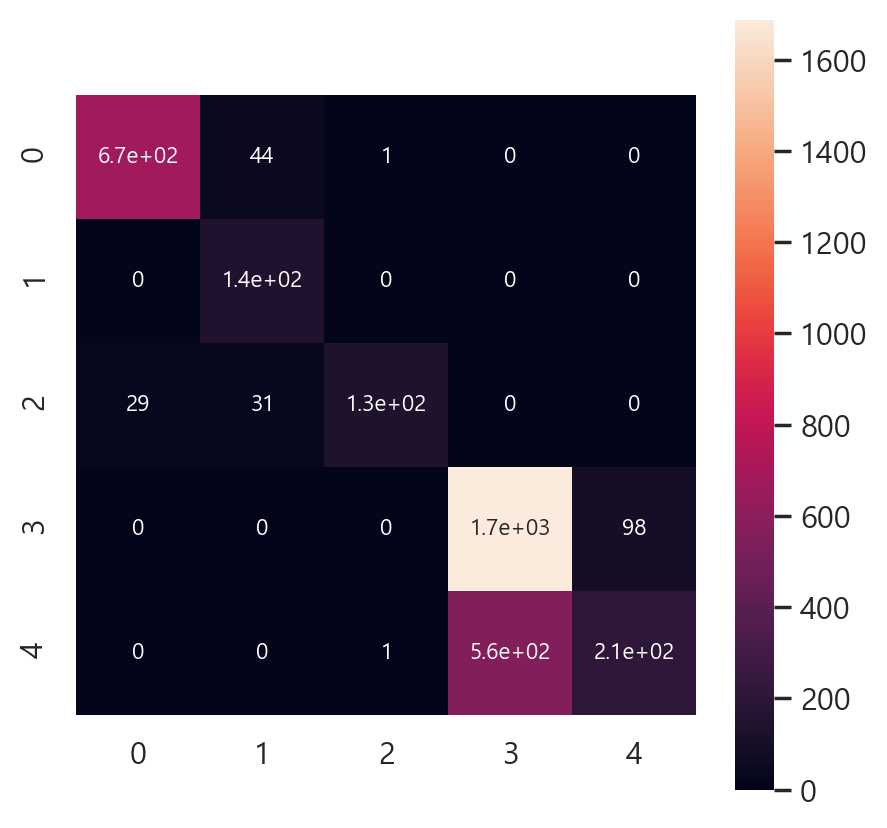

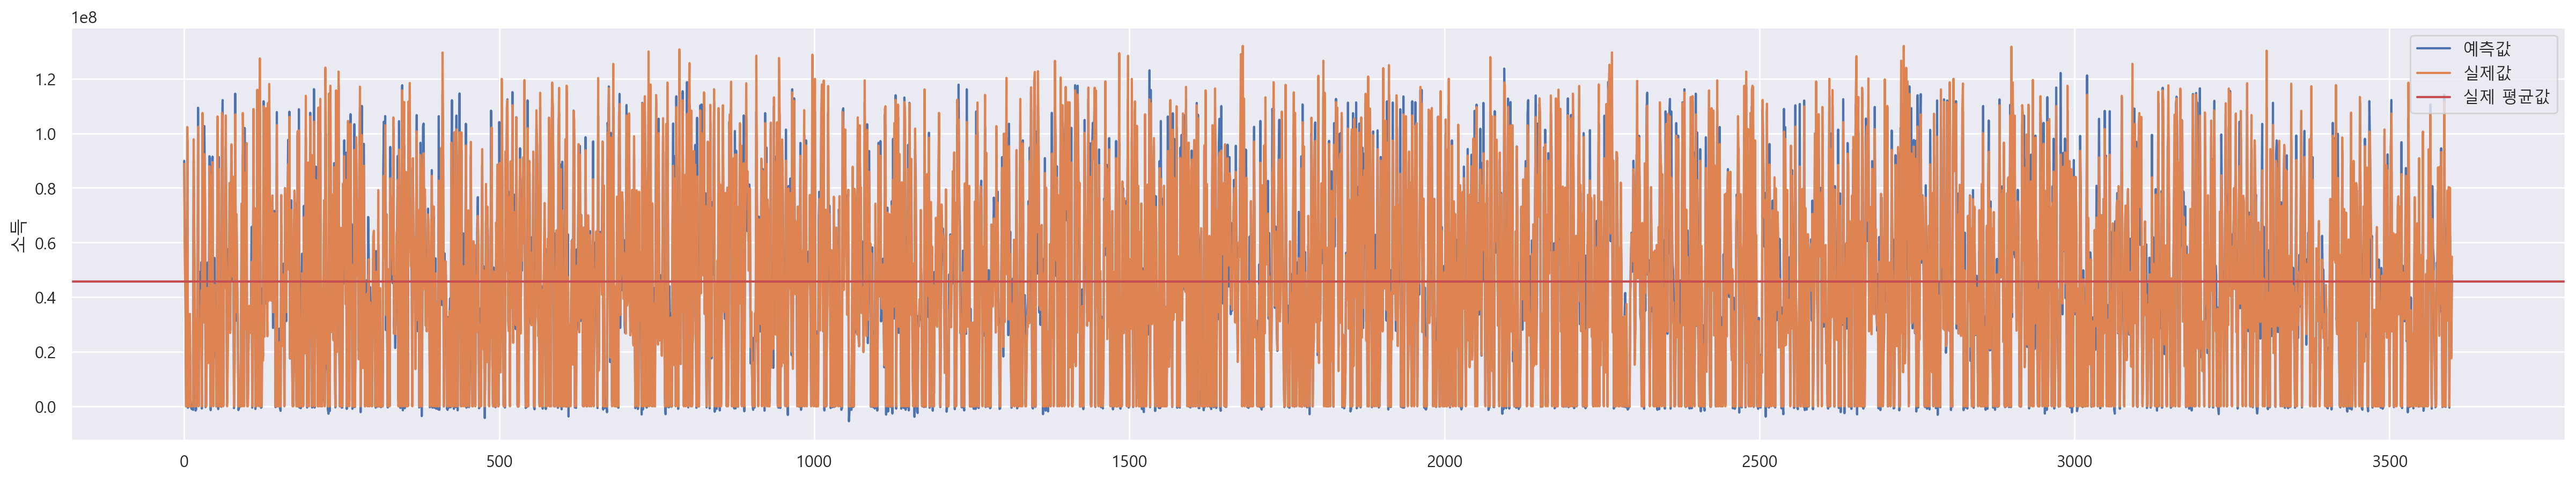

In [102]:
y_pred = xgb_pred
y_pred = pd.DataFrame( y_pred , columns = list(y) )
y_pred['자동차'] = y_pred['자동차'].round().astype(int)
a = confusion_matrix( y_test[target1], y_pred[target1] )
plt.figure( figsize = (5,5))
sns.heatmap( a , annot = True , cbar = True , square= True , annot_kws= {'size': 8} )
plt.show()  
plt.figure( figsize = (30,5))
sns.lineplot(data=y_pred, y=target2, x=y_pred.index ,label = '예측값' )
sns.lineplot(data=y_test, y=target2, x=y_pred.index ,label = '실제값' )
plt.axhline( y_test[target2].mean() , color = 'r' , label = '실제 평균값')
plt.legend()
plt.show()

## LIGHT GBM과 SVM은 target이 2열 이상일때 에러가뜨는 것으로 보임

#### 1.  일반적인 LightGBM 모델 (LGBMClassifier나 LGBMRegressor)는 한 번에 하나의 열 (target)만 예측합니다. 만약 여러 열을 예측하려면 여러 모델을 따로 훈련시켜야 합니다.

#### 2. 회귀용인 SVR은 다중 출력 (멀티 타겟) 문제를 지원하지 않습니다. 하지만 분류용인 SVC는 decision_function_shape='ovr' 옵션을 통해 멀티 클래스 분류 문제를 지원합니다. 그러나 이것은 멀티 클래스 분류 문제를 위한 것이며, 여러개의 독립적인 출력 열에 대한 지원은 아닙니다.

# 2.하이퍼 파라미터 튜닝 시작
결과가 가장 잘나온 모델을 가지고 하이퍼 파라미터 튜닝을 하자. 그리고 선형회귀모델을 튜닝한적이 없으니 시도해보자.

In [58]:
# 평가 및 result 함수에 저장
result1 = pd.DataFrame(columns=['data', 'model_name', 'MAE', 'R2','Accuracy'])
result1

,data,model_name,MAE,R2,Accuracy


In [59]:
from sklearn.model_selection import GridSearchCV

In [60]:
#1 linearReg 릿지CV
from sklearn.linear_model import RidgeCV

alpha = np.linspace(0.1 , 100 , 50)
model_rg = RidgeCV( alphas = alpha , cv = 5)
model_rg.fit( x_train , y_train )

# 성능확인
print('학습성능:', model_rg.score( x_train , y_train))
print('평가성능:', model_rg.score( x_test , y_test))
print('alpha',model_rg.alpha_)

학습성능: 0.44734420256574003
평가성능: 0.44677646933831017
alpha 20.487755102040822


In [61]:
rg_pred = model_rg.predict( x_test )
y_pred = rg_pred
y_pred = pd.DataFrame( y_pred , columns = list(y))
y_pred['자동차'] = y_pred['자동차'].round().astype(int)
print( confusion_matrix( y_test[target1] , y_pred[target1] ))
print( classification_report( y_test[target1] , y_pred[target1] ))
print( 'MAE:' , mean_absolute_error(y_test[target2] , y_pred[target2]))
print( '\nR2:' , r2_score(y_test[target2] , y_pred[target2]))
result1.loc[0] = ['df', 'Ridge',  mean_absolute_error(y_test[target2] , y_pred[target2]), r2_score(y_test[target2] , y_pred[target2]), accuracy_score( y_test[target1] , y_pred[target1] )]
result1

[[   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0   24  146  541    7    0]
 [   1    8   48   78    5    0    0    0]
 [   0    0    0    5   31  154    4    0]
 [   0    0    0    0    0  398 1375   13]
 [   0    0    0    0    0  129  626    7]]
              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         0
          -2       0.00      0.00      0.00         0
          -1       0.00      0.00      0.00         0
           0       0.22      0.03      0.06       718
           1       0.03      0.04      0.03       140
           2       0.13      0.79      0.22       194
           3       0.68      0.77      0.72      1786
           4       0.35      0.01      0.02       762

    accuracy                           0.43      3600
   macro avg       0.18      0.21      0.13      3600
weighted avg       0.47      0.43      0.39      3600

MAE:

,data,model_name,MAE,R2,Accuracy
0,df,Ridge,2.296139e+07,0.491653,0.434722


In [62]:
#2 LinearReg 라쏘
from sklearn.linear_model import MultiTaskLassoCV

alpha = np.linspace(0.1 , 100 , 50 )
model_ls = MultiTaskLassoCV( alphas= alpha , cv = 5 , random_state=1)
model_ls.fit( x_train , y_train)

print('학습성능:', model_ls.score( x_train , y_train))
print('평가성능:', model_ls.score( x_test , y_test))
print('alpha',model_ls.alpha_)

학습성능: 0.4473495203058379
평가성능: 0.4467341237941336
alpha 100.0


In [63]:
lr_el_pred = model_ls.predict( x_test1 )
y_pred = lr_el_pred
y_pred = pd.DataFrame( y_pred , columns = list(y))
y_pred['자동차'] = y_pred['자동차'].round().astype(int)
print( confusion_matrix( y_test[target1] , y_pred[target1] ))
print( classification_report( y_test[target1] , y_pred[target1] ))
print( 'MAE:' , mean_absolute_error(y_test[target2] , y_pred[target2]))
print( '\nR2:' , r2_score(y_test[target2] , y_pred[target2]))
result1.loc[1] = ['df', 'Lasso', mean_absolute_error(y_test[target2] , y_pred[target2]), r2_score(y_test[target2] , y_pred[target2]), accuracy_score( y_test[target1] , y_pred[target1] )]
result1

[[   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0   24  146  541    7    0]
 [   1    8   48   78    5    0    0    0]
 [   0    0    0    5   31  154    4    0]
 [   0    0    0    0    0  397 1374   15]
 [   0    0    0    0    0  128  626    8]]
              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         0
          -2       0.00      0.00      0.00         0
          -1       0.00      0.00      0.00         0
           0       0.22      0.03      0.06       718
           1       0.03      0.04      0.03       140
           2       0.13      0.79      0.22       194
           3       0.68      0.77      0.72      1786
           4       0.35      0.01      0.02       762

    accuracy                           0.43      3600
   macro avg       0.18      0.21      0.13      3600
weighted avg       0.47      0.43      0.39      3600

MAE:

,data,model_name,MAE,R2,Accuracy
0,df,Ridge,2.296139e+07,0.491653,0.434722
1,df,Lasso,2.295575e+07,0.491617,0.434722


In [64]:
#3 linearReg 엘라스틱넷
from sklearn.linear_model import MultiTaskElasticNetCV
l1 = np.linspace(0.01, 1, 100)   
alpha = np.linspace(0.1 , 100, 50)
model_el = MultiTaskElasticNetCV( l1_ratio=l1, alphas = alpha , cv = 5 , random_state=1 )
model_el.fit(x_train , y_train )
print('학습성능:', model_el.score(x_train, y_train))
print('평가성능:', model_el.score(x_test, y_test))
print('-' * 28)
print('l1_ratio:', model_el.l1_ratio_)
print('alpha:', model_el.alpha_)

학습성능: 0.4473354123550282
평가성능: 0.446797936672327
----------------------------
l1_ratio: 0.9600000000000001
alpha: 0.1


In [65]:
lr_el_pred = model_el.predict( x_test1 )
y_pred = lr_el_pred
y_pred = pd.DataFrame( y_pred , columns = list(y))
y_pred['자동차'] = y_pred['자동차'].round().astype(int)
print( confusion_matrix( y_test[target1] , y_pred[target1] ))
print( classification_report( y_test[target1] , y_pred[target1] ))
print( 'MAE:' , mean_absolute_error(y_test[target2] , y_pred[target2]))
print( '\nR2:' , r2_score(y_test[target2] , y_pred[target2]))
result1.loc[2] = ['df', 'ElasticNet', mean_absolute_error(y_test[target2] , y_pred[target2]), r2_score(y_test[target2] , y_pred[target2]), accuracy_score( y_test[target1] , y_pred[target1] )]
result1

[[   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0   23  147  541    7    0]
 [   1    8   48   79    4    0    0    0]
 [   0    0    0    5   31  154    4    0]
 [   0    0    0    0    0  399 1375   12]
 [   0    0    0    0    0  124  631    7]]
              precision    recall  f1-score   support

          -3       0.00      0.00      0.00         0
          -2       0.00      0.00      0.00         0
          -1       0.00      0.00      0.00         0
           0       0.21      0.03      0.06       718
           1       0.02      0.03      0.02       140
           2       0.13      0.79      0.22       194
           3       0.68      0.77      0.72      1786
           4       0.37      0.01      0.02       762

    accuracy                           0.43      3600
   macro avg       0.18      0.20      0.13      3600
weighted avg       0.47      0.43      0.39      3600

MAE:

,data,model_name,MAE,R2,Accuracy
0,df,Ridge,2.296139e+07,0.491653,0.434722
1,df,Lasso,2.295575e+07,0.491617,0.434722
2,df,ElasticNet,2.296501e+07,0.491672,0.434167


In [66]:
#4 하이퍼 파라미터 튜닝 XGB
from xgboost import XGBRegressor
params = {'learning_rate':[0.01,0.05,0.1,0.3], 'max_depth':list(range(1 , 10))}
xgb_model = XGBRegressor()
xgb_hpt_model = GridSearchCV( xgb_model , param_grid= params , cv = 3 , verbose = 2 )
xgb_hpt_model.fit( x_train1 , y_train )

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ....................learning_rate=0.01, max_depth=1; total time=   0.0s
[CV] END ....................learning_rate=0.01, max_depth=1; total time=   0.0s
[CV] END ....................learning_rate=0.01, max_depth=1; total time=   0.0s
[CV] END ....................learning_rate=0.01, max_depth=2; total time=   0.0s
[CV] END ....................learning_rate=0.01, max_depth=2; total time=   0.0s
[CV] END ....................learning_rate=0.01, max_depth=2; total time=   0.1s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=   0.1s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=   0.1s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=   0.1s
[CV] END ....................learning_rate=0.01, max_depth=4; total time=   0.1s
[CV] END ....................learning_rate=0.01, max_depth=4; total time=   0.1s
[CV] END ....................learning_rate=0.01

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             verbose=2)

In [67]:
xgb_pred = xgb_hpt_model.predict( x_test1 )
y_pred = xgb_pred
y_pred = pd.DataFrame( y_pred , columns = list(y))
y_pred['자동차'] = y_pred['자동차'].round().astype(int)
print( confusion_matrix( y_test[target1] , y_pred[target1] ))
print( classification_report( y_test[target1] , y_pred[target1] ))
print( 'MAE:' , mean_absolute_error(y_test[target2] , y_pred[target2]))
print( '\nR2:' , r2_score(y_test[target2] , y_pred[target2]))
result1.loc[3] = ['df', 'XGB_HPT', mean_absolute_error(y_test[target2] , y_pred[target2]), r2_score(y_test[target2] , y_pred[target2]), accuracy_score( y_test[target1] , y_pred[target1] )]
result1

[[ 664   51    3    0    0]
 [   0  140    0    0    0]
 [  22   34  138    0    0]
 [   0    0    0 1658  128]
 [   0    0    0  500  262]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       718
           1       0.62      1.00      0.77       140
           2       0.98      0.71      0.82       194
           3       0.77      0.93      0.84      1786
           4       0.67      0.34      0.45       762

    accuracy                           0.80      3600
   macro avg       0.80      0.78      0.77      3600
weighted avg       0.79      0.80      0.78      3600

MAE: 5281422.056598579

R2: 0.9543634024086184


,data,model_name,MAE,R2,Accuracy
0,df,Ridge,2.296139e+07,0.491653,0.434722
1,df,Lasso,2.295575e+07,0.491617,0.434722
2,df,ElasticNet,2.296501e+07,0.491672,0.434167
3,df,XGB_HPT,5.281422e+06,0.954363,0.795000


In [92]:
y_pred

array([[3.3979192e+00, 8.9519568e+07],
       [3.3486819e+00, 6.3564392e+07],
       [3.3415442e+00, 4.3692996e+07],
       ...,
       [8.4674072e-01, 2.8325616e+07],
       [6.7522563e-02, 1.8171846e+07],
       [3.9488308e+00, 4.9155016e+07]], dtype=float32)

In [95]:
y_pred = xgb_pred
y_pred = pd.DataFrame( y_pred , columns = list(y) )

In [97]:
y_pred

,자동차,소득
0,3.397919,8.951957e+07
1,3.348682,6.356439e+07
2,3.341544,4.369300e+07
3,3.671275,6.622605e+05
4,3.563725,7.473729e+05
...,...,...
3595,1.011899,1.992344e+06
3596,3.730006,6.487688e+07
3597,0.846741,2.832562e+07
3598,0.067523,1.817185e+07


In [98]:
y_pred['자동차'] = y_pred['자동차'].round().astype(int)

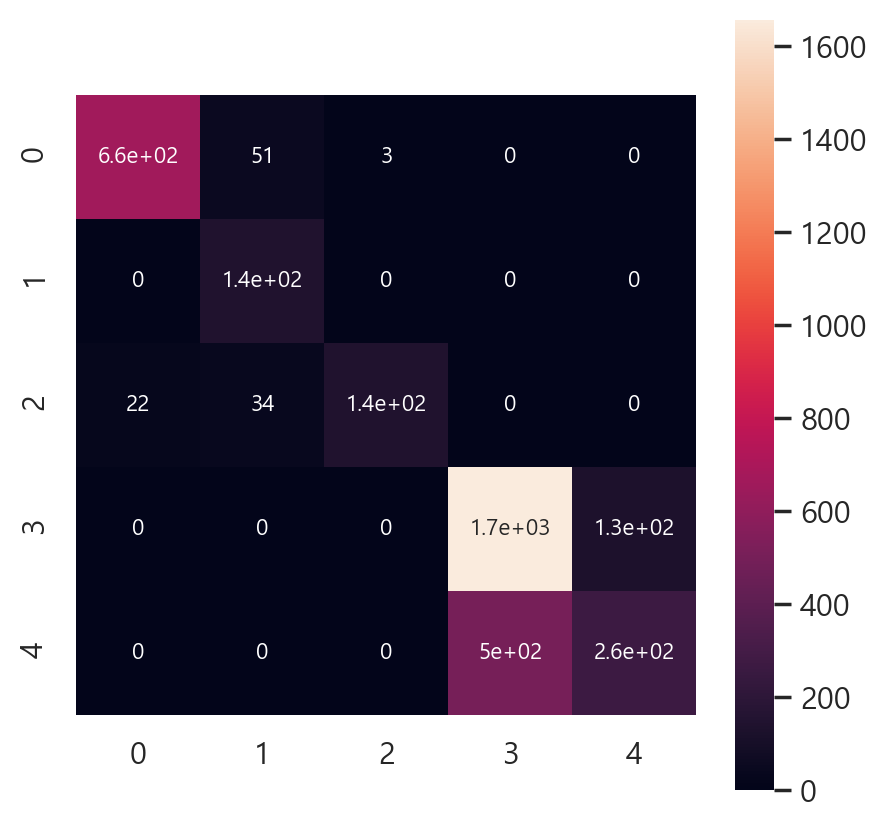

In [99]:
a = confusion_matrix( y_test[target1], y_pred[target1] )
plt.figure( figsize = (5,5))
sns.heatmap( a , annot = True , cbar = True , square= True , annot_kws= {'size': 8} )
plt.show()  

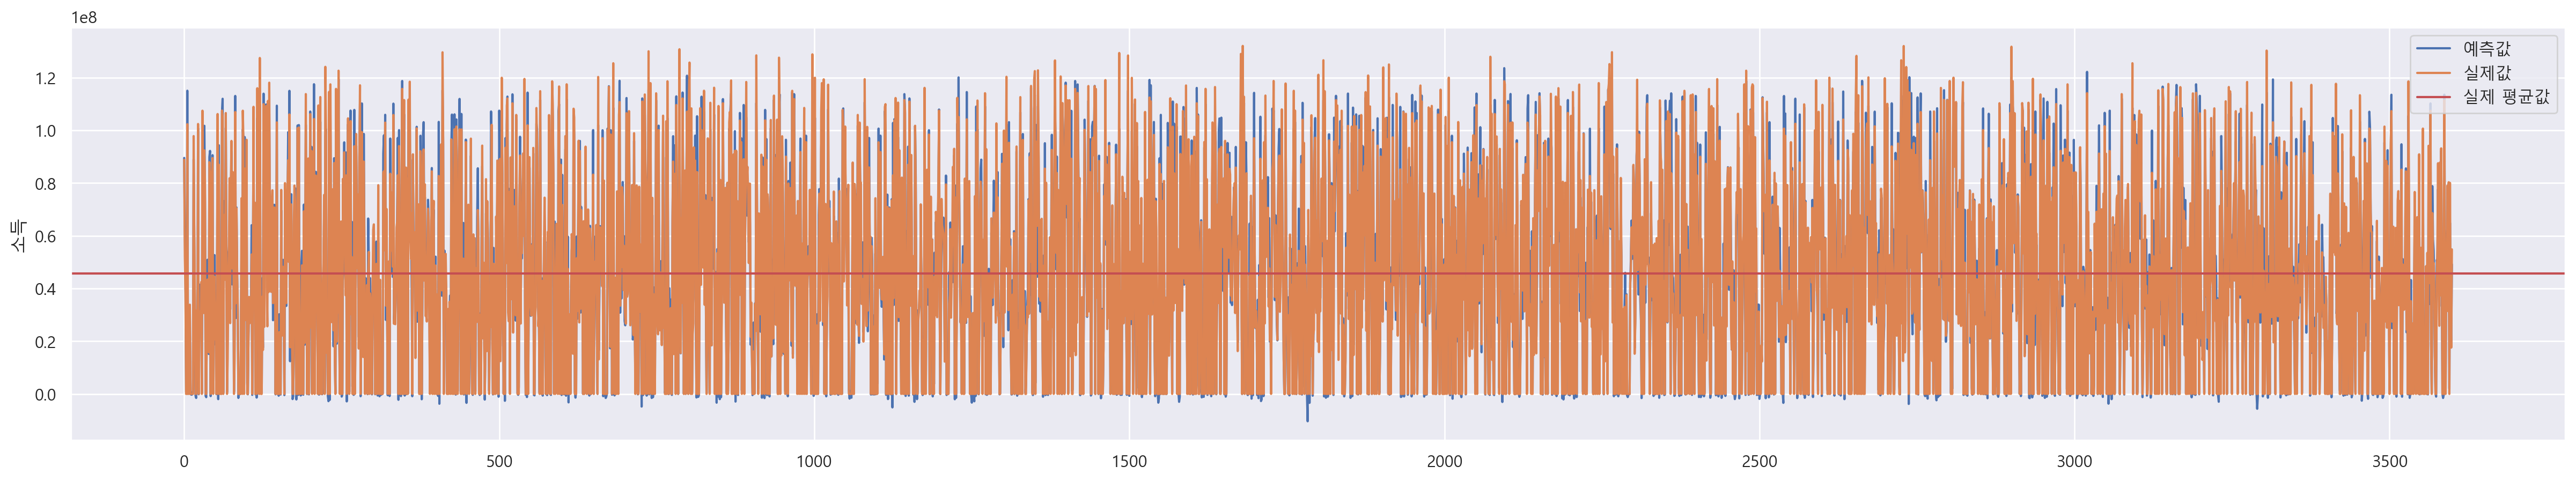

In [100]:
plt.figure( figsize = (30,5))
sns.lineplot(data=y_pred, y=target2, x=y_pred.index ,label = '예측값' )
sns.lineplot(data=y_test, y=target2, x=y_pred.index ,label = '실제값' )
plt.axhline( y_test[target2].mean() , color = 'r' , label = '실제 평균값')
plt.legend()
plt.show()

In [68]:
!pip install tensorflow

In [69]:
#5 DNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.backend import clear_session

In [70]:
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [71]:
n_features = x_train.shape[1]
n_features

19

In [72]:
es = EarlyStopping( monitor='val_loss' , min_delta=0.001 , patience= 5 , mode = 'min')
n_features = x_train.shape[1]

clear_session()

dnn_model = Sequential([Dense(x_train.shape[1]*2,input_shape = (n_features , ),activation = 'relu'),
                        # Dense(4096,activation = 'relu'),
                        # Dense(1024,activation = 'relu'),
                        Dense(64,activation = 'relu'),
                        Dense(16,activation = 'relu'),
                        Dense(8,activation = 'relu'),
                        Dense(2, activation='linear')  # target이 2개이므로 2개의 출력 뉴런
                       ])
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 38)                760       
                                                                 
 dense_1 (Dense)             (None, 64)                2496      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 2)                 18        
                                                                 
Total params: 4450 (17.38 KB)
Trainable params: 4450 (17.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
# learning_rate를 0.1로 주니 21회만에 성공했다. 가능성은 있음

In [74]:
from tensorflow.keras.optimizers import Adam

dnn_model.compile(optimizer = Adam( learning_rate = 0.001 ) , loss = 'mse')

In [75]:
history = dnn_model.fit( x_train , y_train , validation_split=0.2 , callbacks=es,  epochs=1000).history

Epoch 1/1000
210/210 [==============================] - 2s 4ms/step - loss: 1788348951691264.0000 - val_loss: 1805907985956864.0000
Epoch 2/1000
210/210 [==============================] - 0s 2ms/step - loss: 1787528210284544.0000 - val_loss: 1802742729277440.0000
Epoch 3/1000
210/210 [==============================] - 0s 2ms/step - loss: 1774381852262400.0000 - val_loss: 1771661258915840.0000
Epoch 4/1000
210/210 [==============================] - 0s 2ms/step - loss: 1706815574245376.0000 - val_loss: 1650905703251968.0000
Epoch 5/1000
210/210 [==============================] - 0s 2ms/step - loss: 1518068001931264.0000 - val_loss: 1377380845223936.0000
Epoch 6/1000
210/210 [==============================] - 0s 2ms/step - loss: 1187847428112384.0000 - val_loss: 994447668019200.0000
Epoch 7/1000
210/210 [==============================] - 1s 3ms/step - loss: 841917675864064.0000 - val_loss: 703654826868736.0000
Epoch 8/1000
210/210 [==============================] - 0s 2ms/step - loss: 651

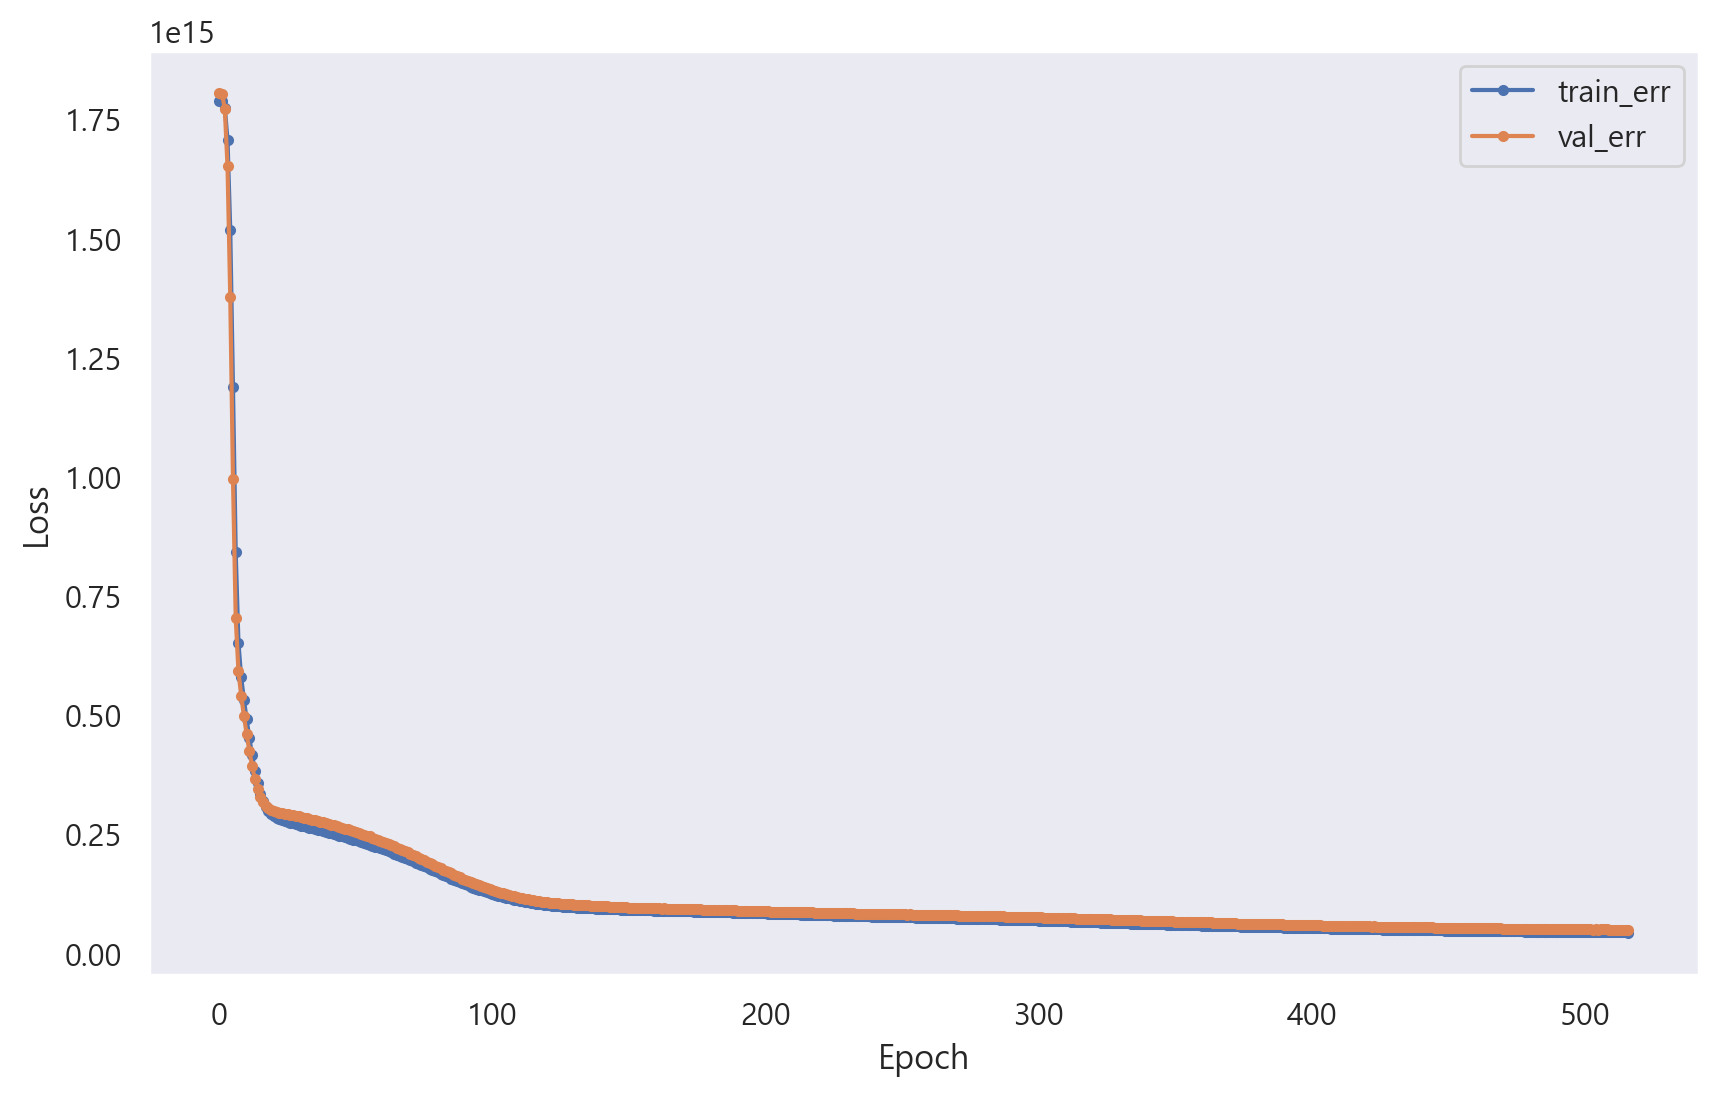

In [76]:
dl_history_plot(history)

In [77]:
dnn_pred = dnn_model.predict(x_test)
dnn_pred

113/113 [==============================] - 0s 1ms/step


array([[-4.4033804e+02,  9.5932920e+07],
       [-4.9677554e+02,  5.6178680e+07],
       [-3.7590054e+02,  4.4377576e+07],
       ...,
       [-1.4386928e+02,  2.0505178e+07],
       [-1.3133803e+02,  2.3700094e+07],
       [-3.5340054e+02,  5.9220724e+07]], dtype=float32)

In [78]:
y_pred = dnn_pred
y_pred = pd.DataFrame( y_pred , columns = list(y))
y_pred

,자동차,소득
0,-440.338043,9.593292e+07
1,-496.775543,5.617868e+07
2,-375.900543,4.437758e+07
3,-452.355408,1.397922e+05
4,-192.601578,2.568553e+05
...,...,...
3595,-49.056782,1.096359e+07
3596,-570.088013,6.141919e+07
3597,-143.869278,2.050518e+07
3598,-131.338028,2.370009e+07


In [79]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# 2D 배열로 변환 후 MinMaxScaler를 사용하여 스케일링
scaled_values = scaler.fit_transform(y_pred['자동차'].values.reshape(-1, 1))

# 스케일링 된 값을 원래 DataFrame에 다시 할당
y_pred['자동차'] = scaled_values*4

In [80]:
y_pred['자동차'] = y_pred['자동차'].round().astype(int)
print( confusion_matrix( y_test[target1] , y_pred[target1] ))
print( classification_report( y_test[target1] , y_pred[target1] ))
print( 'MAE:' , mean_absolute_error(y_test[target2] , y_pred[target2]))
print( '\nR2:' , r2_score(y_test[target2] , y_pred[target2]))
result1.loc[4] = ['df', 'DNN',  mean_absolute_error(y_test[target2] , y_pred[target2]), r2_score(y_test[target2] , y_pred[target2]), accuracy_score( y_test[target1] , y_pred[target1] )]
result1

[[ 10 437 177  90   4]
 [ 11  82  37  10   0]
 [  4 101  58  27   4]
 [ 17 976 520 267   6]
 [ 12 421 227 101   1]]
              precision    recall  f1-score   support

           0       0.19      0.01      0.03       718
           1       0.04      0.59      0.08       140
           2       0.06      0.30      0.10       194
           3       0.54      0.15      0.23      1786
           4       0.07      0.00      0.00       762

    accuracy                           0.12      3600
   macro avg       0.18      0.21      0.09      3600
weighted avg       0.32      0.12      0.13      3600

MAE: 6975762.732511698

R2: 0.9295263049382995


,data,model_name,MAE,R2,Accuracy
0,df,Ridge,2.296139e+07,0.491653,0.434722
1,df,Lasso,2.295575e+07,0.491617,0.434722
2,df,ElasticNet,2.296501e+07,0.491672,0.434167
3,df,XGB_HPT,5.281422e+06,0.954363,0.795000
4,df,DNN,6.975763e+06,0.929526,0.116111


In [81]:
result1.to_csv( '튜닝 및 딥러닝결과3.csv' , index_label= True )

In [82]:
import joblib

# 모델을 학습한 후에 저장할 때
model = xgb_hpt_model  # 모델 학습 함수 호출
joblib.dump(model, 'model_xgb_tun2.pkl')

['model_xgb_tun2.pkl']

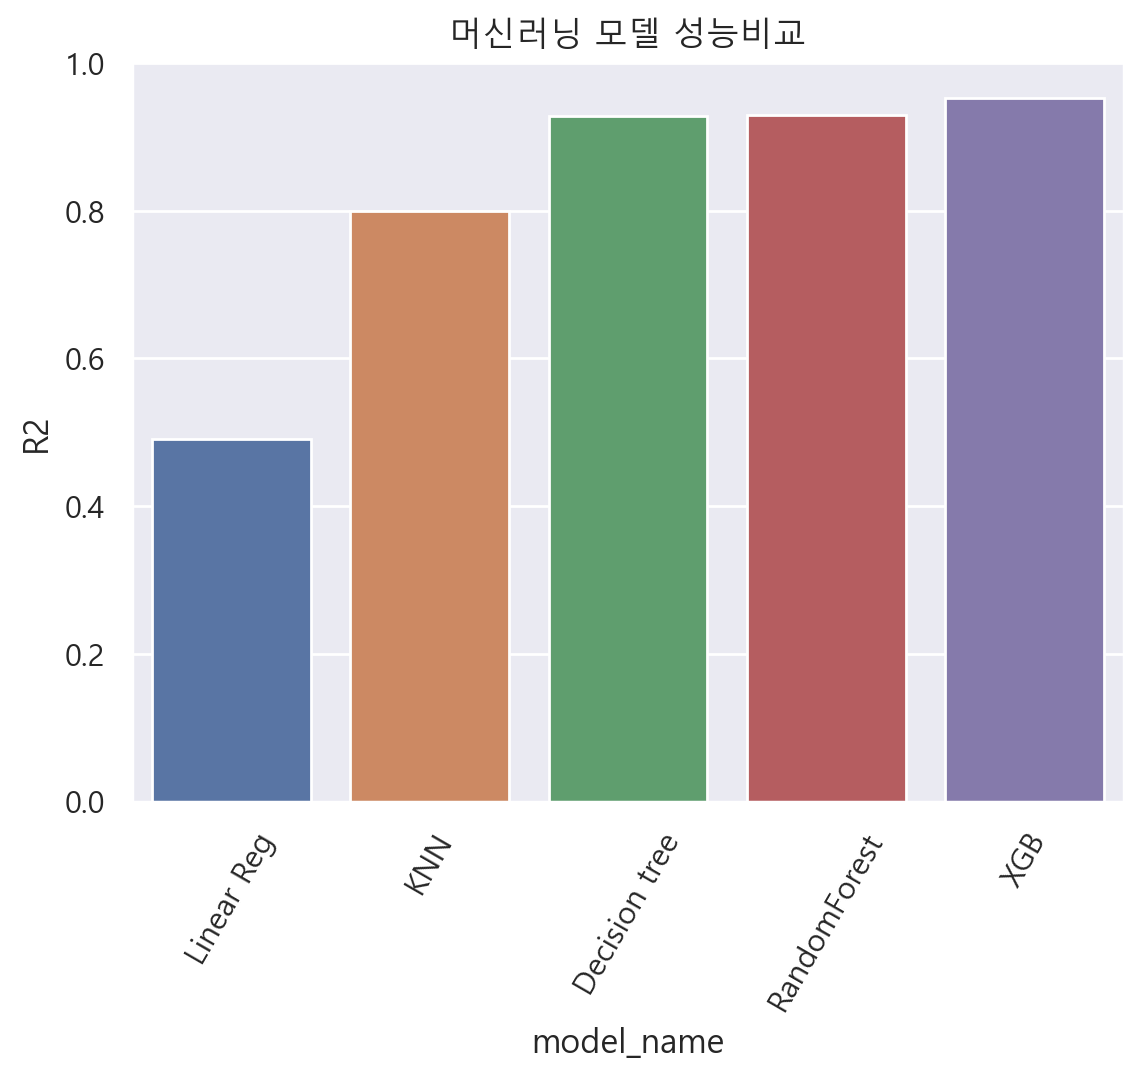

In [83]:
res = result.copy()
res.sort_values( by = 'R2' , inplace= True )
plt.title( '머신러닝 모델 성능비교' )
sns.barplot( x = 'model_name' , y = 'R2' , data = res)
plt.xticks( rotation = 60 )

plt.show()

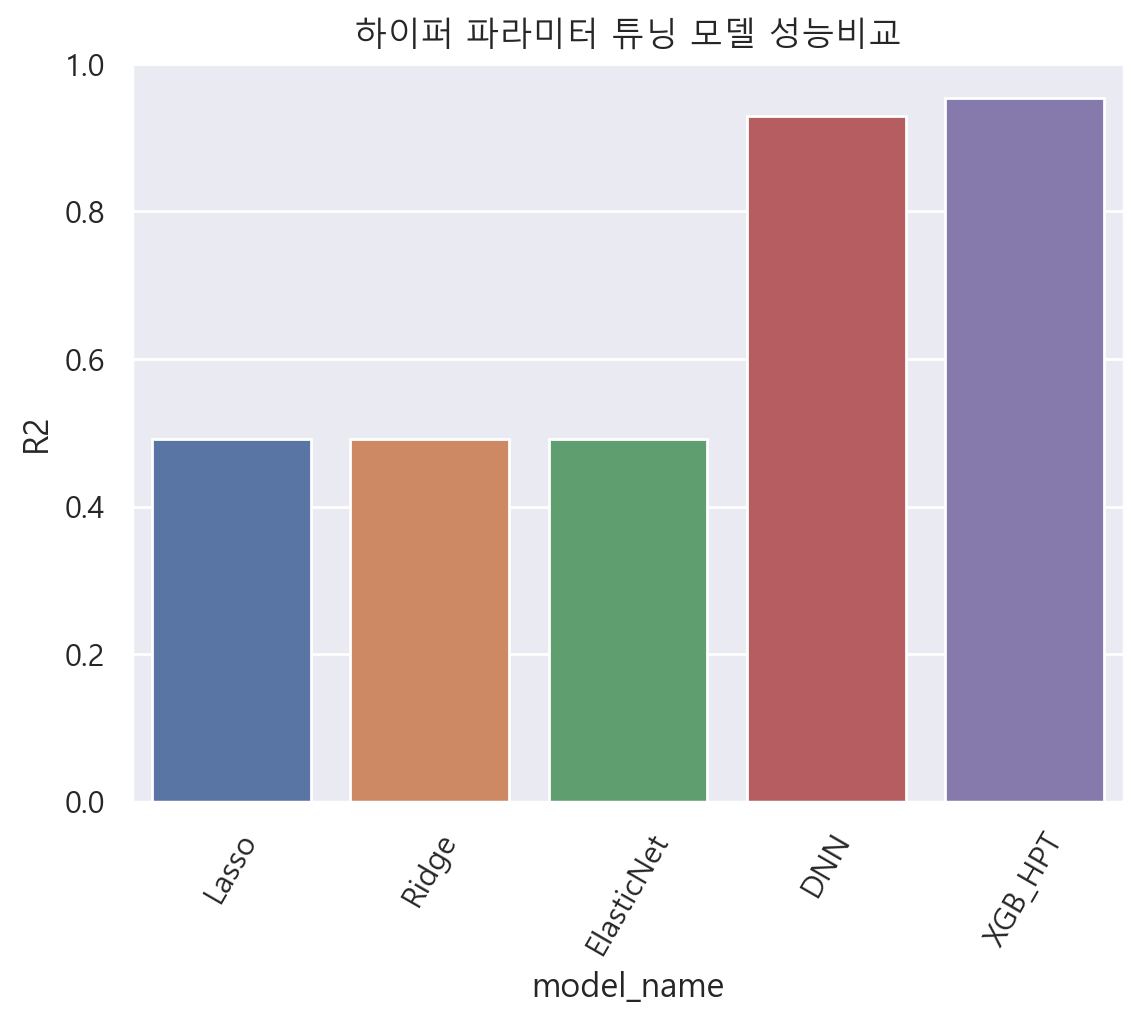

In [84]:
plt.title( '하이퍼 파라미터 튜닝 모델 성능비교' )
res1 = result1.copy()
res1.sort_values( by = 'R2' , inplace= True )
sns.barplot( x = 'model_name' , y = 'R2' , data = res1)
plt.xticks( rotation = 60 )
plt.show()